# Retrieval Augmented Generation - RAG System

**Orchestrated with LangGraph & LangChain**
This notebook demonstrates the construction of an intelligent conversational agent capable of retrieving, analyzing, and synthesizing information from unstructured documents (PDFs).

The system is built on a Graph-based architecture using LangGraph, allowing for cyclic state management and precise control over the Agent-Tool interaction loop.

**System Architecture**
* Orchestration: LangGraph (StateGraph, ToolNode)
* LLM: OpenAI gpt-4o-mini (Temperature = 0 for deterministic outputs)
* Vector Store: ChromaDB (Persistent)
* Embeddings: OpenAI text-embedding-3-large
* Document Processing: PyPDFLoader & RecursiveCharacterTextSplitter


### Workflow Overview

**Ingestion Pipeline:**

* Loads the Monthly Employment Report (Hebrew source).
* Splits the document into manageable chunks (75 chars / 30 overlap).
* Embeds and indexes chunks into a Chroma Vector Store.

**The Agentic Graph:**

* `answer_node`: The central reasoning engine. It receives the user query and decides whether it has enough context or needs to call a tool.
* `tool_node`: Executes the custom @tool named retrieve. This performs a semantic similarity search in the vector store.
* `Conditional Routing`: A logic layer (route function) that dynamically directs the flow between the Agent and the Tools.

**Cross-Language Capability:**

* The source document is in Hebrew.
* The user queries and final answers are processed in English, demonstrating the model's cross-lingual retrieval and synthesis capabilities.

In [7]:
# !pip install langgraph langchain[openai] tavily-python pypdf langchain-community
# !pip install langchain-chroma chromadb

### Import OpenAI API

In [4]:
from google.colab import drive
import os
drive.mount('/content/drive', force_remount = True)

api_key_file = '/content/drive/MyDrive/api_key.txt'
with open(api_key_file, 'r', encoding = 'utf-8-sig') as file:
    api_key = file.read().strip()

print(api_key is not None)
os.environ['OPENAI_API_KEY'] = api_key
print("OpenAI API key loaded:", os.environ.get('OPENAI_API_KEY') is not None)

Mounted at /content/drive
True
OpenAI API key loaded: True


In [23]:
from typing_extensions import TypedDict, List, Literal, Annotated
from tavily import TavilyClient
from uuid import uuid4

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode


from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, SystemMessage, ToolMessage
from langchain_core.tools import tool


from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_chroma import Chroma


llm = ChatOpenAI(model = 'gpt-4o-mini', temperature = 0)

### Create Chroma Vector Store

* `OpenAIEmbeddings` define as the translator, converting all text (both documents and user queries) into numerical vectors that represent their meaning.
* `Chroma` database is initialized to persistently store these vectors, enabling the agent to perform semantic search based on context rather than just keyword matching.

In [44]:
embeddings = OpenAIEmbeddings(model = 'text-embedding-3-large')
vector_store = Chroma(persist_directory = './chroma_db', embedding_function = embeddings)

### Initialize Document Chunking Strategy

The `RecursiveCharacterTextSplitter` is used to break down the large document into smaller, manageable pieces (chunks) for the Vector Store. This is critical for RAG (Retrieval-Augmented Generation) applications, as LLMs have token limits, and vector searches work best on focused content.

**Parameters**

* `chunk_size`: This parameter defines the maximum size (in characters) of the smaller text segments (chunks) generated after splitting.

* `chunk_overlap`: This parameter specifies the number of characters that neighboring chunks will share. Overlap is important because it provides contextual continuity between chunks, preventing sentences or key information from being broken up at the edge of a chunk.

In [45]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size = 75,
                                               chunk_overlap = 30)

### Initialize PDF Loader

In [46]:
PATH = '/content/drive/MyDrive/MonthlyResume.pdf'
loader = PyPDFLoader(file_path = PATH)
docs = loader.load()

### Splitting Documents

Applies the previously defined splitting rules (chunk size and overlap) to the loaded PDF pages (docs), generating a list of small, focused text segments called chunks (all_splits).

In [47]:
all_splits = text_splitter.split_documents(docs)

print(f'Total Pages: {len(docs)}')
print(f'Total final splits: {len(all_splits)}')

Total Pages: 2
Total final splits: 97


### Insert splits into Database

This final step indexes the data into the Vector Store.

It takes all the prepared text chunks (all_splits), converts them into numerical vectors using the defined embedding function, and then permanently stores (persists) these indexed vectors inside the Chroma database on the disk.

In [51]:
_ = vector_store.add_documents(documents = all_splits)     # ID of each split
print(len(_))
print(_[:10])

['7efa475f-9348-4342-a482-e49cb1f79c7a', 'ad0a33a4-9461-4f09-899a-c34cf2b15258', 'f751b3ea-49f1-4be1-adab-00448876a1bd', 'cb15af76-24b2-449a-8338-d7c9058a1f58', '45d1aa0d-2b21-4c55-be1d-6589ea1f2f29', '495ff95c-926b-4d6f-9dc5-3ad8e77aa50b', 'a28512aa-22e0-4fab-95bd-e9c2d62ba10d', '0a59bac0-e5c7-4d10-a814-e43801be209e', '813c7fa9-dc61-4e65-9b06-fc83b2936478', '614e60ff-a644-43b6-8919-072a653f0a28']


In [67]:
@tool
def retrieve(query:str) -> str:
  '''
  Retrieves monthly employment service reports. Provides unemployment statistics,
  demographic breakdowns (academic background, gender, age), and analyzes external factors
  impacting the labor market for the specific month, such as war or economic trends.
  The file is in hebrew but the query ans the response must be in english.
  '''
  retrieve_docs = vector_store.similarity_search(query, k = 2)      # k -> n best similarity chunks fouded
  serialized = "\n\n".join((f'Source: {doc.metadata} \n Content: {doc.page_content}') for doc in retrieve_docs)
  return serialized


# tool list
tool_list = [retrieve]
tool_node = ToolNode(tools = tool_list)
llm_with_tool = llm.bind_tools(tools = tool_list)

In [68]:
class ChatState(TypedDict):
  messages: Annotated[List[BaseMessage], add_messages]


def answer_node(state:ChatState) -> dict:
  human_msg: HumanMessage = state['messages']
  ai_response: AIMessage = llm_with_tool.invoke(input = human_msg)
  return {'messages': [ai_response]}


def route(state:ChatState) -> Literal['tool', 'end']:
  last_msg = state['messages'][-1]
  if hasattr(last_msg, 'tool_calls') and last_msg.tool_calls:
      return 'tool'
  return 'end'

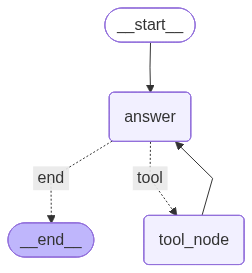

In [72]:
checkpointer = MemorySaver()

builder = StateGraph(ChatState)
builder.add_node('answer', answer_node)
builder.add_node('tool_node', tool_node)

builder.add_edge(START, 'answer')
builder.add_conditional_edges('answer', route, {'tool': 'tool_node', 'end': END})
builder.add_edge('tool_node', 'answer')
builder.add_edge('answer', END)

graph = builder.compile(checkpointer = checkpointer)
graph

In [73]:
cfg = {'configurable': {'thread_id': str(uuid4())}}

* What was the total number of job seekers in August 2025?
* How did "Operation Am Kelavi" impact the employment figures?
* Why did the number of academic job seekers increase in August?
* How does the report compare the Israeli labor market to the US market?

In [126]:
msg = graph.invoke({'messages': [HumanMessage(content = "How did 'Operation Am Kelavi' impact the employment figures?")]}, config = cfg)

In [127]:
msg['messages'][-1].content

'Operation Am Kelavi likely resulted in approximately 133 thousand job seekers registering with the employment service as part of the unemployment benefits program. This indicates a significant impact on employment figures during that period.'

In [128]:
msg

{'messages': [HumanMessage(content='What was the total number of job seekers in August 2025?', additional_kwargs={}, response_metadata={}, id='4ffeeb77-e982-45ef-bb60-ad9a3e0ccfca'),
  AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 110, 'total_tokens': 132, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_11f3029f6b', 'id': 'chatcmpl-CkZa62Z3UQZDUFTjOwyXgQI9mByQX', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--36fcfac0-fe9f-4a5c-8ad5-b040091aa5c6-0', tool_calls=[{'name': 'retrieve', 'args': {'query': 'total number of job seekers in August 2025'}, 'id': 'call_IbtwQvI5nkQsC2x7T3fQwz17', 'type': 'tool_call'}], us

In [143]:
dict_response:dict = {}

for element in msg['messages']:
    if isinstance(element, HumanMessage):
         print("Human Message:")
         print(element)
         print(msg['messages'].index(element))
         dict_response[msg['messages'].index(element)] = element.content
         print()
    if isinstance(element, AIMessage) and element.tool_calls:              # Take the decision to call the Tool
         print("Tool Call:")
         print(element)
         print(msg['messages'].index(element))
         print(f'Tool call: {element.tool_calls[0]['name']}')
         dict_response[msg['messages'].index(element)] = {'tool': element.tool_calls[0]['name']}
         print()

    if isinstance(element, ToolMessage):
        print("Tool Result:")
        print(element)
        print(msg['messages'].index(element))
        print(f'From: {element.content}')
        print()

    if isinstance(element, AIMessage) and not element.tool_calls:
         print("AI Response:")
         print(element)
         print(msg['messages'].index(element))
         dict_response[msg['messages'].index(element)] = element.content

Human Message:
content='What was the total number of job seekers in August 2025?' additional_kwargs={} response_metadata={} id='4ffeeb77-e982-45ef-bb60-ad9a3e0ccfca'
0

Tool Call:
content='' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 110, 'total_tokens': 132, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_11f3029f6b', 'id': 'chatcmpl-CkZa62Z3UQZDUFTjOwyXgQI9mByQX', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None} id='lc_run--36fcfac0-fe9f-4a5c-8ad5-b040091aa5c6-0' tool_calls=[{'name': 'retrieve', 'args': {'query': 'total number of job seekers in August 2025'}, 'id': 'call_IbtwQvI5nkQsC2x7T3fQwz17', 'type': 'tool_call'}] usage_metadata={'input

In [151]:
values = dict_response.values()
new_keys = range(len(dict_response))
new_dict = {new_key: value for new_key, value in zip(new_keys, values)}

for i in range(len(new_dict)):
  print(new_dict[i])


What was the total number of job seekers in August 2025?
{'tool': 'retrieve'}
In August 2025, the total number of job seekers was approximately 186.1 thousand. This represented a decrease of about 32.1 thousand from the previous period.
How did 'Operation Am Kelavi' impact the employment figures?
{'tool': 'retrieve'}
Operation Am Kelavi likely resulted in approximately 133 thousand job seekers registering with the employment service as part of the unemployment benefits program. This indicates a significant impact on employment figures during that period.
